# Dependencies

In [1]:
work_dir = "/home/spaka002/NSF_REU_2024/"

In [2]:
import random
# import wandb
import numpy as np
from dotmap import DotMap

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader

import sys
from notebooks.utilities.helper_functions import *

from notebooks.tensor_completion_models.CoSTCo import *
from notebooks.tensor_completion_models.CPD import *
from notebooks.tensor_completion_models.tuckER import *
from notebooks.tensor_completion_models.ETC import *

import matplotlib.pyplot as plt
from sklearn.utils.validation import check_random_state
import tensorly as tl
from torch.nn.init import xavier_normal_

from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split, KFold

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


In [4]:
data_folder = f"{work_dir}classification_datasets/"
meta_data_folder = f"{work_dir}meta_datasets/"

# Load Tensor

In [5]:
tensor = None
for_queries = False

Query Tensors

In [6]:
# tensor = torch.load(f"{meta_data_folder}query_tensors/AND_AND_801.pt")   # low rank
# tensor = torch.load(f"{meta_data_folder}query_tensors/AND_OR_801.pt")
# tensor = torch.load(f"{meta_data_folder}query_tensors/OR_AND_801.pt")
# tensor = torch.load(f"{meta_data_folder}query_tensors/OR_OR_801.pt")

In [7]:
if (tensor is not None):
    tensor = (tensor - tensor.min())/(tensor.max() - tensor.min())
    for_queries = True

Hyperparameter Tensors

In [8]:
# tensor = torch.load(f"{meta_data_folder}FCNN_Particle_ID_717.pt")       # high rank
# tensor = torch.load(f"{meta_data_folder}FCNN_Spambase_717.pt")


# tensor = torch.load(f"{meta_data_folder}GB_car_evaluation_709.pt")      # low rank
# original_tensor = torch.load(f"{meta_data_folder}SVM_spambase_708.pt")

# tensor = torch.load(f"{meta_data_folder}RF_Alzheimers_805.pt")          # medium rank

In [9]:
# t1 = torch.load(f"{work_dir}meta_datasets/model_mode/RF_car_727.pt")
# t2 = torch.load(f"{work_dir}meta_datasets/model_mode/DT_car_727.pt")
# t3 = torch.load(f"{work_dir}meta_datasets/model_mode/GB_car_728.pt")
# t4 = torch.load(f"{work_dir}meta_datasets/model_mode/ET_car_730.pt")

# tensor1 = torch.stack((t1, t2, t3, t4))

# del t1, t2, t3, t4

# t1 = torch.load(f"{work_dir}meta_datasets/model_mode/RF_glass_728.pt")
# t2 = torch.load(f"{work_dir}meta_datasets/model_mode/DT_glass_728.pt")
# t3 = torch.load(f"{work_dir}meta_datasets/model_mode/GB_glass_728.pt")
# t4 = torch.load(f"{work_dir}meta_datasets/model_mode/ET_glass_730.pt")

# tensor2 = torch.stack((t1, t2, t3, t4))

# del t1, t2, t3, t4

# t1 = torch.load(f"{work_dir}meta_datasets/model_mode/RF_bodyPerformance_731.pt")
# t2 = torch.load(f"{work_dir}meta_datasets/model_mode/DT_bodyPerformance_731.pt")
# t3 = torch.load(f"{work_dir}meta_datasets/model_mode/GB_bodyPerformance_731.pt")
# t4 = torch.load(f"{work_dir}meta_datasets/model_mode/ET_bodyPerformance_731.pt")

# tensor3 = torch.stack((t1, t2, t3, t4))

# del t1, t2, t3, t4

# t1 = torch.load(f"{work_dir}meta_datasets/model_mode/RF_Dermatology_802.pt")
# t2 = torch.load(f"{work_dir}meta_datasets/model_mode/DT_Dermatology_802.pt")
# t3 = torch.load(f"{work_dir}meta_datasets/model_mode/GB_Dermatology_802.pt")
# t4 = torch.load(f"{work_dir}meta_datasets/model_mode/ET_Dermatology_802.pt")

# tensor4 = torch.stack((t1, t2, t3, t4))

# del t1, t2, t3, t4


# tensor = torch.stack((tensor1, tensor2, tensor3, tensor4))

# del tensor1, tensor2, tensor3, tensor4

In [10]:
print(f"Tensor shape: {tensor.shape}")
total_cells = 1
for s in tensor.shape: total_cells*=s

print(f"{total_cells} total cells in tensor.")

Tensor shape: torch.Size([5, 8, 7, 8])
2240 total cells in tensor.


# Train & Evaluate

In [11]:
portion = 0.025          # 0.025, 0.05, 0.075, 0.1

num_iterations = 10      # 3, 5, 10

In [12]:
lr = 5e-3
wd = 1e-4
num_epochs = 10000
batch_size = 256

cpd_rank = 3
costco_rank = 25
tuckER_rank = 3

In [13]:
cpd_errors = list()
costco_errors = list()
tuckER_errors = list()

ensemble_mlp_errors = list()
ensemble_mlp2_errors = list()


print('Iteration:', end = ' ')
for it in range(num_iterations):
    
    sparse_tensor = get_sparse_tensor(t = tensor.clone(), portion = portion)
    
    model=train_tensor_completion(model_type = 'tuckER', 
                                  train_indices = sparse_tensor.indices().t(),
                                  train_values = sparse_tensor.values(), 
                                  tensor_size = sparse_tensor.size(),
                                  rank = tuckER_rank, 
                                  num_epochs = num_epochs, 
                                  batch_size = batch_size, 
                                  tucker_in_drop=0.15,
                                  tucker_hidden_drop=0.25,
                                  lr=lr, 
                                  wd=wd, 
                                  early_stopping = True, 
                                  flags = 15, 
                                  verbose = False, 
                                  epoch_display_rate = 1, 
                                  return_errors = False,
                                  convert_to_cpd=False,
                                  for_queries=for_queries)

    it_tuckER_errors = get_unique_MAE(model = model,
                                      full_t = tensor,
                                      sparse_t = sparse_tensor,
                                      return_errors = True)
    del model


    model=train_tensor_completion(model_type = 'cpd', 
                                  train_indices = sparse_tensor.indices().t(),
                                  train_values = sparse_tensor.values(), 
                                  tensor_size = sparse_tensor.size(),
                                  rank = cpd_rank, 
                                  num_epochs = num_epochs, 
                                  batch_size = batch_size, 
                                  lr=lr, 
                                  wd=wd, 
                                  early_stopping = True, 
                                  flags = 15, 
                                  verbose = False, 
                                  epoch_display_rate = 1, 
                                  return_errors = False,
                                  for_queries=for_queries)

    it_cpd_errors = get_unique_MAE(model = model,
                                   full_t = tensor,
                                   sparse_t = sparse_tensor,
                                   return_errors = True)
    del model


    model=train_tensor_completion(model_type = 'costco', 
                                  train_indices = sparse_tensor.indices().t(),
                                  train_values = sparse_tensor.values(), 
                                  tensor_size = sparse_tensor.size(),
                                  rank = costco_rank, 
                                  num_epochs = num_epochs, 
                                  batch_size = batch_size, 
                                  lr=lr, 
                                  wd=wd, 
                                  early_stopping = True, 
                                  flags = 20, 
                                  verbose = False, 
                                  return_errors = False,
                                  convert_to_cpd = False,
                                  for_queries=for_queries)

    it_costco_errors = get_unique_MAE(model = model,
                                      full_t = tensor,
                                      sparse_t = sparse_tensor,
                                      return_errors = True)
    del model



# ___________________________________________ ensemble_model _______________________________________________________________________________________________

    # good for high rank tensors (FCNN)
    ensemble_model = ETC(sparse_tensor=sparse_tensor,
                        models_type_rank = [
                                            'cpd_3', 'cpd_5',
                                            'tuckER_5'
                                            ],
                        num_splits=10,                   # train on all splits but one --> num_splits = 10 means train on 90% of data
                        use_all_train_values = False,    # all models train on all data
                        use_unique_train_values = False, # all models have unique data (doesn't do any good)
                        mlp_hidden_dim1=128,             # first layer
                        mlp_hidden_dim2=None,            # second layer (set to None if you don't want second layer)
                        dropout_p=0.1,                   # dropout after MLP
                        dropout_p_before_mlp = 0.0,      # dropout before MLP
                        tucker_in_drop=0.15,
                        tucker_hidden_drop=0.25,
                        lr = lr,
                        wd = wd,
                        num_epochs = num_epochs,
                        batch_size = batch_size,
                        further_train_individuals = False,
                        for_queries=for_queries).to(device)

# __________________________________________________________________________________________________________________________________________________________

    ensemble_model.set_agg_func('learned_mlp')          
    ensemble_model = train_learned_ensemble(model = ensemble_model,
                                            sparse_tensor = ensemble_model.sparse_tensor,
                                            lr=lr,
                                            wd=wd,
                                            num_epochs=num_epochs,
                                            batch_size=batch_size,
                                            flags=20,
                                            early_stopping=True,
                                            verbose=False)


    it_ensemble_mlp_errors = get_unique_MAE(model = ensemble_model,
                                            full_t = tensor,
                                            sparse_t = sparse_tensor,
                                            return_errors = True)


    del ensemble_model
    
    
    # ___________________________________________ ensemble_model 2 _____________________________________________________________________________________________

    # good for high rank tensors (FCNN)
    ensemble_model = ETC(sparse_tensor=sparse_tensor,
                        models_type_rank = [
                                            'cpd_2', 'cpd_3'
                                            # 'tuckER_3'
                                            ],
                        num_splits=10,                   # train on all splits but one --> num_splits = 10 means train on 90% of data
                        use_all_train_values = False,    # all models train on all data
                        use_unique_train_values = False, # all models have unique data (doesn't do any good)
                        mlp_hidden_dim1=128,             # first layer
                        mlp_hidden_dim2=None,            # second layer (set to None if you don't want second layer)
                        dropout_p=0.1,                   # dropout after MLP
                        dropout_p_before_mlp = 0.0,      # dropout before MLP
                        tucker_in_drop=0.15,
                        tucker_hidden_drop=0.25,
                        lr = lr,
                        wd = wd,
                        num_epochs = num_epochs,
                        batch_size = batch_size,
                        further_train_individuals = False,
                        for_queries=for_queries).to(device)
# __________________________________________________________________________________________________________________________________________________________


    ensemble_model.set_agg_func('learned_mlp')          
    ensemble_model = train_learned_ensemble(model = ensemble_model,
                                            sparse_tensor = ensemble_model.sparse_tensor,
                                            lr=lr,
                                            wd=wd,
                                            num_epochs=num_epochs,
                                            batch_size=batch_size,
                                            flags=20,
                                            early_stopping=True,
                                            verbose=False)


    it_ensemble_mlp2_errors = get_unique_MAE(model = ensemble_model,
                                            full_t = tensor,
                                            sparse_t = sparse_tensor,
                                            return_errors = True)


    del ensemble_model


    cpd_errors += [it_cpd_errors]
    costco_errors += [it_costco_errors]
    tuckER_errors += [it_tuckER_errors]

    ensemble_mlp_errors += [it_ensemble_mlp_errors]
    ensemble_mlp2_errors += [it_ensemble_mlp2_errors]

    del it_cpd_errors, it_costco_errors, it_tuckER_errors
    del it_ensemble_mlp_errors, it_ensemble_mlp2_errors

    print(it+1, end = ' ')


cpd_errors =              np.array(cpd_errors)
costco_errors =           np.array(costco_errors)
tuckER_errors =           np.array(tuckER_errors)

ensemble_mlp_errors =     np.array(ensemble_mlp_errors)
ensemble_mlp2_errors =    np.array(ensemble_mlp2_errors)

print("\nAll Done!")

Iteration: 

1 2 3 4 5 6 7 8 9 10 
All Done!


In [14]:
print(f'CPD:      {[np.round(x, 3) for x in cpd_errors.mean(axis=1)]}')
print(f'CoSTCo:   {[np.round(x, 3) for x in costco_errors.mean(axis=1)]}')
print(f'MLP:      {[np.round(x, 3) for x in ensemble_mlp_errors.mean(axis=1)]}')
print(f'MLP2:     {[np.round(x, 3) for x in ensemble_mlp2_errors.mean(axis=1)]}')
# print(f'MLP Diff: {[f"{100*np.round(x, 2)}%" for x in ((ensemble_mlp_errors.mean(axis=1) - ensemble_mlp2_errors.mean(axis=1))/ensemble_mlp_errors.mean(axis=1))]}')

CPD:      [0.202, 0.224, 0.225, 0.199, 0.179, 0.154, 0.216, 0.22, 0.181, 0.221]
CoSTCo:   [0.074, 0.103, 0.105, 0.125, 0.112, 0.141, 0.092, 0.112, 0.1, 0.102]
MLP:      [0.147, 0.147, 0.146, 0.213, 0.156, 0.15, 0.135, 0.165, 0.133, 0.14]
MLP2:     [0.135, 0.124, 0.144, 0.134, 0.138, 0.104, 0.13, 0.149, 0.116, 0.106]


In [15]:
x = [
     f'TuckER Rank {tuckER_rank} Error ({tuckER_errors.mean(axis=1).mean():.3f})',
     f'CPD Rank {cpd_rank} Error ({cpd_errors.mean(axis=1).mean():.3f})',
     f'CoSTCo Rank {costco_rank} Error ({costco_errors.mean(axis=1).mean():.3f})',
     f'Ensemble (MLP) Error ({ensemble_mlp_errors.mean(axis=1).mean():.3f})',
     f'Ensemble (MLP2) Error ({ensemble_mlp2_errors.mean(axis=1).mean():.3f})'
     ]

avgs = [
        tuckER_errors.mean(axis=1).mean(),
        cpd_errors.mean(axis=1).mean(),
        costco_errors.mean(axis=1).mean(),
        ensemble_mlp_errors.mean(axis=1).mean(), 
        ensemble_mlp2_errors.mean(axis=1).mean()
        ]

stds = [
        tuckER_errors.mean(axis=1).std(),
        cpd_errors.mean(axis=1).std(),
        costco_errors.mean(axis=1).std(),
        ensemble_mlp_errors.mean(axis=1).std(), 
        ensemble_mlp2_errors.mean(axis=1).std() 
        ]

In [24]:
x[0].split("Error")[0][:-1]

'TuckER Rank 3'

In [34]:
f = lambda x, y = 15: str(x) + (" "*(y-len(str(x))))

for i in range(len(x)):
    print(f"{f(x[i].split('Error')[0][:-1])} | Mean: {avgs[i]:.4f} | Std: {stds[i]:.4f}")

TuckER Rank 3   | Mean: 0.2951 | Std: 0.0144
CPD Rank 3      | Mean: 0.2021 | Std: 0.0227
CoSTCo Rank 25  | Mean: 0.1067 | Std: 0.0172
Ensemble (MLP)  | Mean: 0.1532 | Std: 0.0219
Ensemble (MLP2) | Mean: 0.1280 | Std: 0.0145


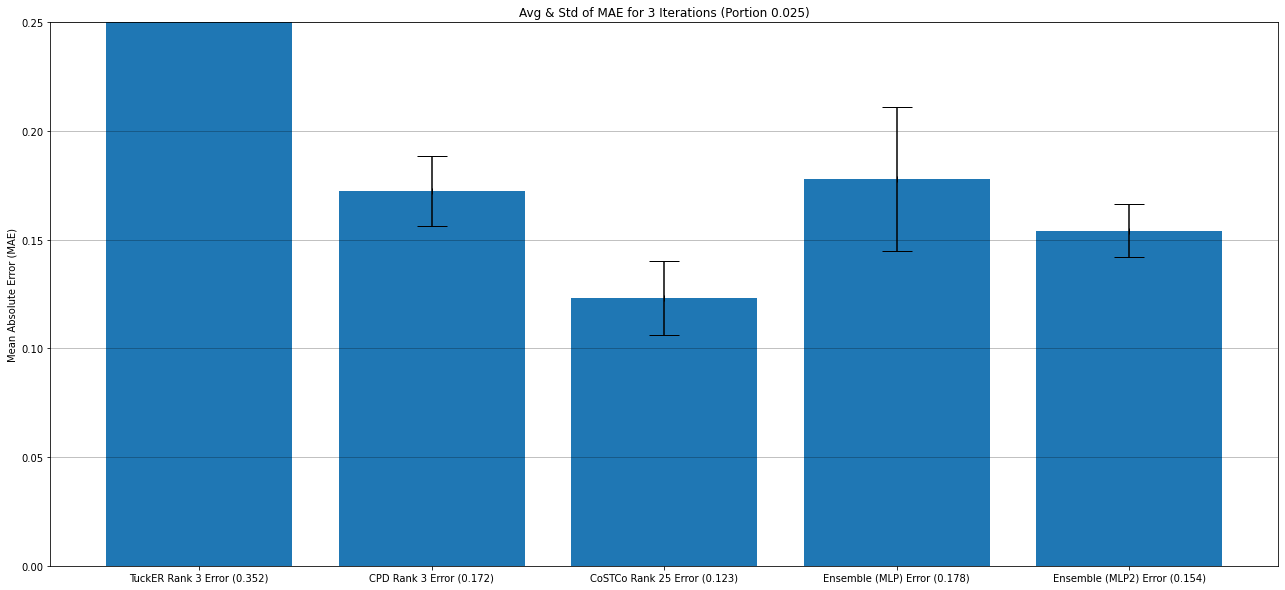

In [ ]:
plt.figure(figsize=(22, 10))

plt.bar(x, avgs)
plt.errorbar(x, avgs, yerr=stds, fmt = '|', color='black', capsize=15)

plt.title(f"Avg & Std of MAE for {num_iterations} Iterations (Portion {portion})")

plt.ylabel('Mean Absolute Error (MAE)')
plt.grid(axis='y', linestyle='-', alpha=0.3, zorder=0, color='black')

# plt.yticks([ {y ticks you want} ])

plt.ylim(0, 0.25)
# plt.ylim(bottom = 0)


plt.show()